In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


The problem is pretty straight forward. I need to predict whether a person on the space ship transported to an alternate dimension or not

The input variables I have are

* PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
* HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
* CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
* Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
* Destination - The planet the passenger will be debarking to.
* Age - The age of the passenger.
* VIP - Whether the passenger has paid for special VIP service during the voyage.
* RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
* Name - The first and last names of the passenger.

This is clearly a classification type problem. The score metrics that I will use are 
* Confusion Matrix
* Accuracy
* Precesion
* Recall
* F1 Score

Cost function - As mentioned in the problem statement/evaluation metrics I will try to get best accuracy. I will tune the parameters to improve accuracy based on the accuracy I got from each model with default parameters.

# Importing Necessary libraries

In [2]:
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report, ConfusionMatrixDisplay
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

In [3]:
!pip install xgboost
from xgboost import XGBClassifier
np.random.seed(1)

# Importing Scored Data

In [4]:
shipDataRaw = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
outDataRaw = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')

In [5]:
shipDataRaw.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False


In [6]:
outDataRaw.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus


# Cleaning and preprocessing the data

In [7]:
outDataRaw.columns = [s.strip() for s in outDataRaw.columns]
outDataRaw.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name'],
      dtype='object')

In [8]:
shipDataRaw.columns = [s.strip() for s in shipDataRaw.columns] 
shipDataRaw.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

In [9]:
shipDataRaw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [10]:
outDataRaw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


## Dropping unnecessary columns PassengerId, Name. 

In [11]:
shipData = shipDataRaw.drop(['PassengerId', 'Name'], axis=1)
outData = outDataRaw.drop(['PassengerId', 'Name'], axis=1)

# Checking for null values

In [12]:
shipData.isna().sum()

HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Transported       0
dtype: int64

In [13]:
outData.isna().sum()

HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
dtype: int64

# Imputing missing values before data partiotining

Based on the above observations I came to following conclusions
* I will convert object values True, false to boolean values 1,0.
* In cabin I seperate cabin to cabin deck, cabin side and cabin num and drop cabin num.
* I will do onehot encoding for remaining object data types which have strings as values.
* Missing values for objects will also be encoded.
* Missing boolean values will be replaced with 0.



In [14]:
shipData['CryoSleep'] = shipData['CryoSleep'].fillna(0).astype(int)
shipData['VIP'] = shipData['VIP'].fillna(0).astype(int)
shipData['Transported'] = shipData['Transported'].fillna(0).astype(int)

In [15]:
outData['CryoSleep'] = outData['CryoSleep'].fillna(0).astype(int)
outData['VIP'] = outData['VIP'].fillna(0).astype(int)

In [16]:
shipData['HomePlanet'] = shipData['HomePlanet'].fillna('unknown')
shipData['Cabin'] = shipData['Cabin'].fillna('unknown/unknown/unknown')
shipData['Destination'] = shipData['Destination'].fillna('unknown')


In [17]:
outData['HomePlanet'] = outData['HomePlanet'].fillna('unknown')
outData['Cabin'] = outData['Cabin'].fillna('unknown/unknown/unknown')
outData['Destination'] = outData['Destination'].fillna('unknown')

# Encoding the objects

In [18]:
objectsList = list(shipData.select_dtypes(include='object').columns)
for obj in objectsList:
    print(f"{obj}: {shipData[obj].unique()}\n")

HomePlanet: ['Europa' 'Earth' 'Mars' 'unknown']

Cabin: ['B/0/P' 'F/0/S' 'A/0/S' ... 'G/1499/S' 'G/1500/S' 'E/608/S']

Destination: ['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e' 'unknown']



In [19]:
shipData[['CabinDeck', 'CabinNum', 'CabinSide']] = shipData['Cabin'].str.split('/', expand=True)
shipData = shipData.drop(['Cabin','CabinNum'], axis=1)
shipData.head(5)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,CabinDeck,CabinSide
0,Europa,0,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,0,B,P
1,Earth,0,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0,1,F,S
2,Europa,0,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,A,S
3,Europa,0,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,A,S
4,Earth,0,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,565.0,2.0,1,F,S


In [20]:
objectsList = list(outData.select_dtypes(include='object').columns)
for obj in objectsList:
    print(f"{obj}: {outData[obj].unique()}\n")

HomePlanet: ['Earth' 'Europa' 'Mars' 'unknown']

Cabin: ['G/3/S' 'F/4/S' 'C/0/S' ... 'D/296/P' 'D/297/P' 'G/1498/S']

Destination: ['TRAPPIST-1e' '55 Cancri e' 'PSO J318.5-22' 'unknown']



In [21]:
outData[['CabinDeck', 'CabinNum', 'CabinSide']] = outData['Cabin'].str.split('/', expand=True)
outData = outData.drop(['Cabin','CabinNum'], axis=1)
outData.head(2)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CabinDeck,CabinSide
0,Earth,1,TRAPPIST-1e,27.0,0,0.0,0.0,0.0,0.0,0.0,G,S
1,Earth,0,TRAPPIST-1e,19.0,0,0.0,9.0,0.0,2823.0,0.0,F,S


In [22]:
onehot_df = pd.get_dummies(shipData['HomePlanet'], prefix='HomePlanet', drop_first=False)
shipData = shipData.join(onehot_df).drop('HomePlanet', axis=1)

onehot_df = pd.get_dummies(shipData['CabinDeck'], prefix='CabinDeck', drop_first=False)
shipData = shipData.join(onehot_df).drop('CabinDeck', axis=1)

onehot_df = pd.get_dummies(shipData['CabinSide'], prefix='CabinSide', drop_first=False)
shipData = shipData.join(onehot_df).drop('CabinSide', axis=1)

onehot_df = pd.get_dummies(shipData['Destination'], prefix='Destination', drop_first=False)
shipData = shipData.join(onehot_df).drop('Destination', axis=1)


In [23]:
onehot_df = pd.get_dummies(outData['HomePlanet'], prefix='HomePlanet', drop_first=False)
outData = outData.join(onehot_df).drop('HomePlanet', axis=1)

onehot_df = pd.get_dummies(outData['CabinDeck'], prefix='CabinDeck', drop_first=False)
outData = outData.join(onehot_df).drop('CabinDeck', axis=1)

onehot_df = pd.get_dummies(outData['CabinSide'], prefix='CabinSide', drop_first=False)
outData = outData.join(onehot_df).drop('CabinSide', axis=1)

onehot_df = pd.get_dummies(outData['Destination'], prefix='Destination', drop_first=False)
outData = outData.join(onehot_df).drop('Destination', axis=1)


## Spliting the data for training and testing (data partitoning 80/20)

The data set is a good one with 8,693 observations. So I decided to partiton the data for 80% for training and 20% for testing which I believe will give good results.

In [24]:
train_df, test_df = train_test_split(shipData, test_size=0.2)

## Seperating the predictors and traget variables

In [25]:
targetColumn = 'Transported'
predictors = list(shipData.columns)
predictors.remove(targetColumn)
target = [targetColumn]


# Impute missing values after data partiotining

In [26]:
imputer = SimpleImputer(strategy="median")
train_cols_with_na = list(train_df.isna().sum()[train_df.isna().sum() > 0].index)
test_cols_with_na = list(test_df.isna().sum()[test_df.isna().sum() > 0].index)
train_df[train_cols_with_na] = imputer.fit_transform(train_df[train_cols_with_na])
test_df[test_cols_with_na] = imputer.fit_transform(test_df[test_cols_with_na])

In [27]:
out_cols_with_na = list(outData.isna().sum()[outData.isna().sum() > 0].index)
outData[out_cols_with_na] = imputer.fit_transform(outData[out_cols_with_na])

ship_cols_with_na = list(shipData.isna().sum()[shipData.isna().sum() > 0].index)
shipData[ship_cols_with_na] = imputer.fit_transform(shipData[ship_cols_with_na])

In [28]:
shipData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CryoSleep                  8693 non-null   int64  
 1   Age                        8693 non-null   float64
 2   VIP                        8693 non-null   int64  
 3   RoomService                8693 non-null   float64
 4   FoodCourt                  8693 non-null   float64
 5   ShoppingMall               8693 non-null   float64
 6   Spa                        8693 non-null   float64
 7   VRDeck                     8693 non-null   float64
 8   Transported                8693 non-null   int64  
 9   HomePlanet_Earth           8693 non-null   uint8  
 10  HomePlanet_Europa          8693 non-null   uint8  
 11  HomePlanet_Mars            8693 non-null   uint8  
 12  HomePlanet_unknown         8693 non-null   uint8  
 13  CabinDeck_A                8693 non-null   uint8

In [29]:
outData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CryoSleep                  4277 non-null   int64  
 1   Age                        4277 non-null   float64
 2   VIP                        4277 non-null   int64  
 3   RoomService                4277 non-null   float64
 4   FoodCourt                  4277 non-null   float64
 5   ShoppingMall               4277 non-null   float64
 6   Spa                        4277 non-null   float64
 7   VRDeck                     4277 non-null   float64
 8   HomePlanet_Earth           4277 non-null   uint8  
 9   HomePlanet_Europa          4277 non-null   uint8  
 10  HomePlanet_Mars            4277 non-null   uint8  
 11  HomePlanet_unknown         4277 non-null   uint8  
 12  CabinDeck_A                4277 non-null   uint8  
 13  CabinDeck_B                4277 non-null   uint8

# Standardizing the input variables

In [30]:
scaler = preprocessing.StandardScaler()
std_pred = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']   
train_df[std_pred] = scaler.fit_transform(train_df[std_pred])
test_df[std_pred] = scaler.transform(test_df[std_pred])

In [31]:
outData[std_pred] = scaler.fit_transform(outData[std_pred])
shipData[std_pred] = scaler.fit_transform(shipData[std_pred])

In [32]:
outData.head(3)

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,...,CabinDeck_G,CabinDeck_T,CabinDeck_unknown,CabinSide_P,CabinSide_S,CabinSide_unknown,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Destination_unknown
0,1,-0.114147,0,-0.357339,-0.283840,-0.312173,-0.267841,-0.246712,1,0,...,1,0,0,0,1,0,0,0,1,0
1,0,-0.684313,0,-0.357339,-0.277879,-0.312173,2.287504,-0.246712,1,0,...,0,0,0,0,1,0,0,0,1,0
2,1,0.170937,0,-0.357339,-0.283840,-0.312173,-0.267841,-0.246712,0,1,...,0,0,0,0,1,0,1,0,0,0


In [33]:
shipData_X = shipData.drop(['Transported'], axis=1)
shipData.head(3)

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,HomePlanet_Earth,...,CabinDeck_G,CabinDeck_T,CabinDeck_unknown,CabinSide_P,CabinSide_S,CabinSide_unknown,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Destination_unknown
0,0,0.711945,0,-0.333105,-0.281027,-0.283579,-0.270626,-0.263003,0,0,...,0,0,0,1,0,0,0,0,1,0
1,0,-0.334037,0,-0.168073,-0.275387,-0.241771,0.217158,-0.224205,1,1,...,0,0,0,0,1,0,0,0,1,0
2,0,2.036857,1,-0.268001,1.959998,-0.283579,5.695623,-0.219796,0,0,...,0,0,0,0,1,0,0,0,1,0


In [34]:
shipData_y = shipData[['Transported']]
shipData_y.head(3)

,Transported
0,0
1,1
2,0


# Saving the data sets for testing and training

In [35]:
X_train = train_df[predictors]
y_train = train_df[target]
X_test = test_df[predictors]
y_test = test_df[target]

In [36]:
X_train.head(3)

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,...,CabinDeck_G,CabinDeck_T,CabinDeck_unknown,CabinSide_P,CabinSide_S,CabinSide_unknown,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Destination_unknown
5776,1,0.706771,0,-0.328390,-0.279781,-0.2737,-0.276084,-0.258226,0,0,...,0,0,0,1,0,0,0,0,1,0
220,0,0.985951,0,-0.328390,0.270753,-0.2737,-0.276084,-0.258226,1,0,...,0,0,0,1,0,0,0,0,1,0
2398,0,-0.340152,0,-0.300489,0.139319,-0.2737,-0.252719,-0.258226,1,0,...,1,0,0,0,1,0,0,0,1,0


In [37]:
y_train.head(3)

,Transported
5776,0
220,0
2398,0


In [38]:
X_test.head(3)

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,...,CabinDeck_G,CabinDeck_T,CabinDeck_unknown,CabinSide_P,CabinSide_S,CabinSide_unknown,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Destination_unknown
1454,0,0.218207,0,-0.249092,2.064950,-0.273700,-0.257212,-0.253899,0,1,...,0,0,0,0,1,0,1,0,0,0
218,1,-0.130768,0,-0.328390,-0.279781,-0.273700,-0.276084,-0.258226,1,0,...,1,0,0,0,1,0,0,1,0,0
7866,0,-0.340152,0,-0.202100,0.134980,-0.272055,-0.276084,-0.258226,1,0,...,0,0,0,0,1,0,0,1,0,0


In [39]:
y_test.head(3)

,Transported
1454,1
218,0
7866,0


# Now I will create different models and explore the results to find best accurate model.

In [40]:
performance = pd.DataFrame({"model": [], "accuracy": [], "precision": [],"recall": [], "f1": []})

# Logistic Regression Model

In [41]:
logRegModel = LogisticRegression()
_ = logRegModel.fit(X_train, np.ravel(y_train))

In [42]:
y_pred = logRegModel.predict(X_test)

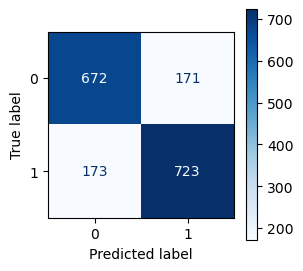

In [43]:
# display the confusion matrix
matrix = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=matrix)
fig,ax = plt.subplots(figsize=(3, 3))
display.plot(ax=ax, cmap=plt.cm.Blues)
plt.show()

In [44]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

performance = pd.concat([performance, pd.DataFrame({"model": 'Logestic Regression', "accuracy": [accuracy], 
                                                    "precision": [precision], "recall": [recall], 
                                                    "f1": [f1]})])

In [45]:
#for i in range(100):
sgd_reg = SGDClassifier(random_state=0)
sgd_reg.fit(X_train, np.ravel(y_train))
y_pred = sgd_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
if accuracy >= 0.8130:
    print(f"for ivalue:766 accuracy:{accuracy}")


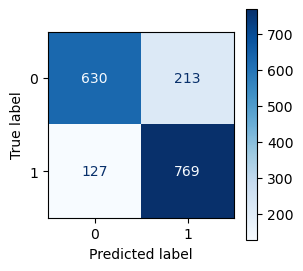

In [46]:
# display the confusion matrix
matrix = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=matrix)
fig,ax = plt.subplots(figsize=(3, 3))
display.plot(ax=ax, cmap=plt.cm.Blues)
plt.show()

In [47]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

performance = pd.concat([performance, pd.DataFrame({"model": 'SGD Classifier', "accuracy": [accuracy], 
                                                    "precision": [precision], "recall": [recall], 
                                                    "f1": [f1]})])
performance

,model,accuracy,precision,recall,f1
0,Logestic Regression,0.802185,0.808725,0.806920,0.807821
0,SGD Classifier,0.804485,0.783096,0.858259,0.818956


# Prediction with Decision Tree (using default parameters)

In [48]:
decTree = DecisionTreeClassifier()
_ = decTree.fit(X_train, np.ravel(y_train))

y_pred = decTree.predict(X_test)

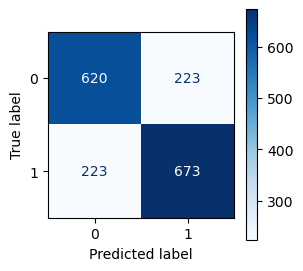

In [49]:
# display the confusion matrix
matrix = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=matrix)
fig,ax = plt.subplots(figsize=(3, 3))
display.plot(ax=ax, cmap=plt.cm.Blues)
plt.show()


In [50]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

performance = pd.concat([performance, pd.DataFrame({"model": 'Decision Tree', "accuracy": [accuracy], 
                                                    "precision": [precision], "recall": [recall], 
                                                    "f1": [f1]})])

# Ensemble Techniques
## Prediction with Random Forest (using default parameters)

In [51]:
randForest = RandomForestClassifier()
_ = randForest.fit(X_train, np.ravel(y_train))

y_pred = randForest.predict(X_test)

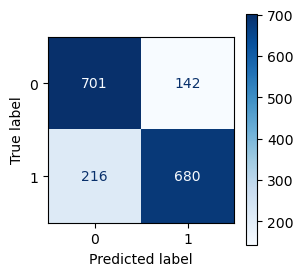

In [52]:
# display the confusion matrix
matrix = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=matrix)
fig,ax = plt.subplots(figsize=(3, 3))
display.plot(ax=ax, cmap=plt.cm.Blues)
plt.show()

In [53]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

performance = pd.concat([performance, pd.DataFrame({"model": 'Random Forest', "accuracy": [accuracy], 
                                                    "precision": [precision], "recall": [recall], 
                                                    "f1": [f1]})])

## Prediction with ADABoost (using default parameters)

In [54]:
adaBoost = AdaBoostClassifier()
_ = adaBoost.fit(X_train, np.ravel(y_train))

y_pred = adaBoost.predict(X_test)

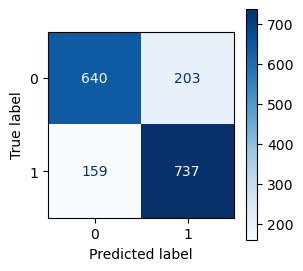

In [55]:
# display the confusion matrix
matrix = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=matrix)
fig,ax = plt.subplots(figsize=(3, 3))
display.plot(ax=ax, cmap=plt.cm.Blues)
plt.show()

In [56]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

performance = pd.concat([performance, pd.DataFrame({"model": 'ADA Boost', "accuracy": [accuracy], 
                                                    "precision": [precision], "recall": [recall], 
                                                    "f1": [f1]})])

## Prediction with Gradient Boost (using default parameters)

In [57]:
gradBoost = GradientBoostingClassifier()
_ = gradBoost.fit(X_train, np.ravel(y_train))

y_pred = gradBoost.predict(X_test)

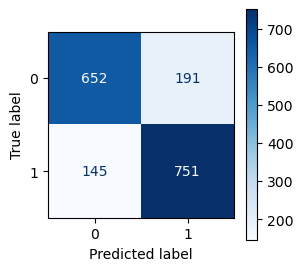

In [58]:
# display the confusion matrix
matrix = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=matrix)
fig,ax = plt.subplots(figsize=(3, 3))
display.plot(ax=ax, cmap=plt.cm.Blues)
plt.show()

In [59]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

performance = pd.concat([performance, pd.DataFrame({"model": 'Gradient Boost', "accuracy": [accuracy], 
                                                    "precision": [precision], "recall": [recall], 
                                                    "f1": [f1]})])

# Prediction with XG Boost (using default parameters)

In [60]:
xgBoost = XGBClassifier()
_ = xgBoost.fit(X_train, np.ravel(y_train))

y_pred = xgBoost.predict(X_test)

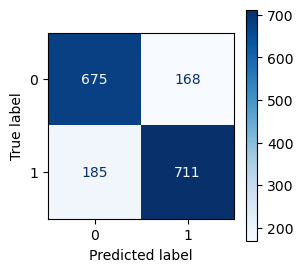

In [61]:
# display the confusion matrix
matrix = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=matrix)
fig,ax = plt.subplots(figsize=(3, 3))
display.plot(ax=ax, cmap=plt.cm.Blues)
plt.show()

In [62]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

performance = pd.concat([performance, pd.DataFrame({"model": 'XG Boost', "accuracy": [accuracy], 
                                                    "precision": [precision], "recall": [recall], 
                                                    "f1": [f1]})])

# Prediction with Neural Networks (using default parameters)

In [63]:
NNModel = MLPClassifier(max_iter=1000)
_ = NNModel.fit(X_train, np.ravel(y_train))

y_pred = NNModel.predict(X_test)

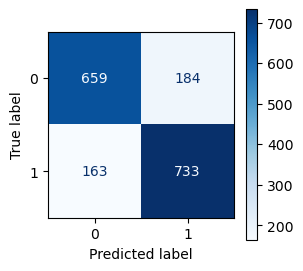

In [64]:
# display the confusion matrix
matrix = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=matrix)
fig,ax = plt.subplots(figsize=(3, 3))
display.plot(ax=ax, cmap=plt.cm.Blues)
plt.show()

In [65]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

performance = pd.concat([performance, pd.DataFrame({"model": 'Neural Networks', "accuracy": [accuracy], 
                                                    "precision": [precision], "recall": [recall], 
                                                    "f1": [f1]})])

In [66]:
performance

,model,accuracy,precision,recall,f1
0,Logestic Regression,0.802185,0.808725,0.806920,0.807821
0,SGD Classifier,0.804485,0.783096,0.858259,0.818956
0,Decision Tree,0.743531,0.751116,0.751116,0.751116
0,Random Forest,0.794135,0.827251,0.758929,0.791618
0,ADA Boost,0.791834,0.784043,0.822545,0.802832
0,Gradient Boost,0.806786,0.797240,0.838170,0.817193
0,XG Boost,0.797010,0.808874,0.793527,0.801127
0,Neural Networks,0.800460,0.799346,0.818080,0.808605


# Results Discussion

A we can see Ensemble model Gradiant boosting gave me best accuracy so far. Not just accurcy all other score metrics are better for Gradient boosting. But neural networks tend to have more accuracy when trained more. since the final output will be trained on more data I will go with neural networks model.

# Prediction using Gradient Boost with RandonSearchCV

score = "accuracy"
kfolds = 5

parameters = {
    'hidden_layer_sizes': [ (32,), (64,), (128,), (32,16), (64,32)],
    'activation': ['logistic', 'tanh', 'relu'],
    'solver': ['adam', 'sgd'],
    'alpha': [0, .2, .5, .7, 1],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'learning_rate_init': [0.0001, 0.001, 0.01],
    'max_iter': [9000]
}

NNModel = MLPClassifier()
randomSearch = RandomizedSearchCV(estimator = NNModel, param_distributions=parameters, cv=kfolds, n_iter=1000,
                           scoring=score, verbose=0, n_jobs=-1,
                           random_state=1, return_train_score=True)

_ = randomSearch.fit(X_train, np.ravel(y_train))


randomBestModel = randomSearch.best_estimator_
y_pred = randomBestModel.predict(X_test)

# display the confusion matrix
matrix = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=matrix)
fig,ax = plt.subplots(figsize=(3, 3))
display.plot(ax=ax, cmap=plt.cm.Blues)
plt.show()

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

performance = pd.concat([performance, pd.DataFrame({"model": 'Random Search on G Boost', "accuracy": [accuracy], 
                                                    "precision": [precision], "recall": [recall], 
                                                    "f1": [f1]})])

performance

# Prediction using Gradient Boost with GridSearchCV

score = "accuracy"

kfolds = 5
min_samples_split = randomSearch.best_params_['min_samples_split']
min_samples_leaf = randomSearch.best_params_['min_samples_leaf']
min_impurity_decrease = randomSearch.best_params_['min_impurity_decrease']
max_leaf_nodes = randomSearch.best_params_['max_leaf_nodes']
max_depth = randomSearch.best_params_['max_depth']
criterion = randomSearch.best_params_['criterion']

parameters = {
    'min_samples_split': np.arange(min_samples_split-2,min_samples_split+2),  
    'min_samples_leaf': np.arange(min_samples_leaf-2,min_samples_leaf+2),
    'min_impurity_decrease': np.arange(min_impurity_decrease-0.0001, min_impurity_decrease+0.0001, 0.00005),
    'max_leaf_nodes': np.arange(max_leaf_nodes-2,max_leaf_nodes+2), 
    'max_depth': np.arange(max_depth-2,max_depth+2), 
    'criterion': [criterion]
}

gridSearch = GridSearchCV(estimator = gradBoost, param_grid=parameters, cv=kfolds, 
                           scoring=score, verbose=1, n_jobs=-1,  # n_jobs=-1 will utilize all available CPUs 
                           return_train_score=True)

_ = gridSearch.fit(X_train, np.ravel(y_train))


gridBestModel = gridSearch.best_estimator_
y_pred = gridBestModel.predict(X_test)

# display the confusion matrix
matrix = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=matrix)
fig,ax = plt.subplots(figsize=(3, 3))
display.plot(ax=ax, cmap=plt.cm.Blues)
plt.show()

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

performance = pd.concat([performance, pd.DataFrame({"model": 'Grid Search on G Boost', "accuracy": [accuracy], 
                                                    "precision": [precision], "recall": [recall], 
                                                    "f1": [f1]})])


# Final Results

performance

# Loading Unscored Data

In [67]:
shipData.head(3)

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,HomePlanet_Earth,...,CabinDeck_G,CabinDeck_T,CabinDeck_unknown,CabinSide_P,CabinSide_S,CabinSide_unknown,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Destination_unknown
0,0,0.711945,0,-0.333105,-0.281027,-0.283579,-0.270626,-0.263003,0,0,...,0,0,0,1,0,0,0,0,1,0
1,0,-0.334037,0,-0.168073,-0.275387,-0.241771,0.217158,-0.224205,1,1,...,0,0,0,0,1,0,0,0,1,0
2,0,2.036857,1,-0.268001,1.959998,-0.283579,5.695623,-0.219796,0,0,...,0,0,0,0,1,0,0,0,1,0


In [68]:
outData.head(3)

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,...,CabinDeck_G,CabinDeck_T,CabinDeck_unknown,CabinSide_P,CabinSide_S,CabinSide_unknown,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Destination_unknown
0,1,-0.114147,0,-0.357339,-0.283840,-0.312173,-0.267841,-0.246712,1,0,...,1,0,0,0,1,0,0,0,1,0
1,0,-0.684313,0,-0.357339,-0.277879,-0.312173,2.287504,-0.246712,1,0,...,0,0,0,0,1,0,0,0,1,0
2,1,0.170937,0,-0.357339,-0.283840,-0.312173,-0.267841,-0.246712,0,1,...,0,0,0,0,1,0,1,0,0,0


# Preprocessing unscored data

# Generating our predicted profiles and adding them to unscored dataset

In [69]:
finalModel = MLPClassifier(max_iter=1000)
_ = finalModel.fit(shipData_X, np.ravel(shipData_y))

In [70]:
predictedOutput = finalModel.predict(outData).astype(bool)

In [71]:
output_evaluation = pd.DataFrame({'PassengerId': outDataRaw['PassengerId'], 'Transported': predictedOutput}) 

In [72]:
output_evaluation.head(5)

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


# Saving our new dataset into CSV files.

In [73]:
output_evaluation.to_csv('/kaggle/working/submission.csv', index=False)